In [142]:
import torch
from gsnn.models.GSNN import GSNN
from gsnn.interpret.GSNNExplainer import GSNNExplainer
from gsnn.interpret.ContrastiveIGExplainer import ContrastiveIGExplainer
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from gsnn_mds.data.AMLDataset import AMLDataset

from gsnn.interpret.CounterfactualExplainer import CounterfactualExplainer 
from gsnn.interpret.ContrastiveOcclusionExplainer import ContrastiveOcclusionExplainer
from gsnn.interpret.utils import plot_edge_importance
from gsnn.interpret.NoiseTunnel import NoiseTunnel 

import seaborn as sbn 

%load_ext autoreload
%autoreload 2 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = torch.load('../workflow/exp/default/gsnn/gsnn_model.pt', weights_only=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.eval() 
model = model.to(device) 

batch_size = 256


In [4]:
aml_expr = pd.read_csv('../proc/aml_expr.csv')
data = torch.load('../proc/graph.pt', weights_only=False)
drug = pd.read_csv('../proc/resp.csv')

aml_expr = aml_expr.fillna(0)

id2x = {} 
expr_ixs = np.array([i for i,n in enumerate(data.node_names_dict['input']) if "EXPR__" in n])
expr_names = np.array(data.node_names_dict['input'])[expr_ixs]
for i,row in aml_expr.iterrows(): 
    x = torch.zeros(len(data.node_names_dict['input']), dtype=torch.float32)
    x[expr_ixs] = torch.tensor(row[expr_names].values.astype(np.float32), dtype=torch.float32)
    id2x[row.id] = x

drug_inputs = [x.split('__')[1] for x in data.node_names_dict['input'] if x.split('__')[0] == 'DRUG']


In [ ]:
ids = drug[lambda x: x.partition == 'test'].id.unique() 
inhibitor = ['venetoclax'] #['gw-2580'] #['gw-2580 + otx-015']
response = 0 

synth_drug = pd.DataFrame({'id': ids, 'partition': 'infer', 'response': response, 'inhibitor': inhibitor*len(ids)})

synth_drug = synth_drug.assign(inhibitor_1 = [x.split(' + ')[0] for x in inhibitor*len(ids)])

#if l
#synth_drug = synth_drug.assign(inhibitor_2 = [x.split(' + ')[1] for x in inhibitor*len(ids)])
synth_drug = synth_drug.assign(inhibitor_2 = None) 

synth_drug.head() 

,id,partition,response,inhibitor,inhibitor_1,inhibitor_2
0,13e131bc-c3ab-405e-9a98-1efef18edcd2,infer,0,venetoclax,venetoclax,None
1,2dddf646-4970-4b1e-b69a-22fecc8f19dd,infer,0,venetoclax,venetoclax,None
2,858e591d-56e2-4dbe-832b-ea07ab44ec4c,infer,0,venetoclax,venetoclax,None
3,312ade73-8b93-4487-8329-80ea3175c434,infer,0,venetoclax,venetoclax,None
4,8344248a-9bab-4b5b-b857-c8e8dcc30956,infer,0,venetoclax,venetoclax,None


In [69]:
pred_dataset = AMLDataset(id2x, synth_drug, data.node_names_dict['input'])
pred_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=256, shuffle=False) 

print(f'Number of predictions: {len(pred_dataset)}')

Number of predictions: 38


In [70]:
yhat = [] 
xs = [] 

with torch.no_grad(): 
    for x, _ in pred_loader:
        xs.append(x.cpu()) 
        x = x.to(device) 
        yhat.append(model(x).cpu()) 

yhat = torch.cat(yhat, axis=0) 
xs = torch.cat(xs, axis=0) 

yhat = yhat.reshape(-1) 

synth_drug = synth_drug.assign(yhat = yhat) 
synth_drug.head() 

,id,partition,response,inhibitor,inhibitor_1,inhibitor_2,yhat
0,13e131bc-c3ab-405e-9a98-1efef18edcd2,infer,0,venetoclax,venetoclax,None,-0.046635
1,2dddf646-4970-4b1e-b69a-22fecc8f19dd,infer,0,venetoclax,venetoclax,None,-0.006400
2,858e591d-56e2-4dbe-832b-ea07ab44ec4c,infer,0,venetoclax,venetoclax,None,0.245779
3,312ade73-8b93-4487-8329-80ea3175c434,infer,0,venetoclax,venetoclax,None,0.045360
4,8344248a-9bab-4b5b-b857-c8e8dcc30956,infer,0,venetoclax,venetoclax,None,0.085932


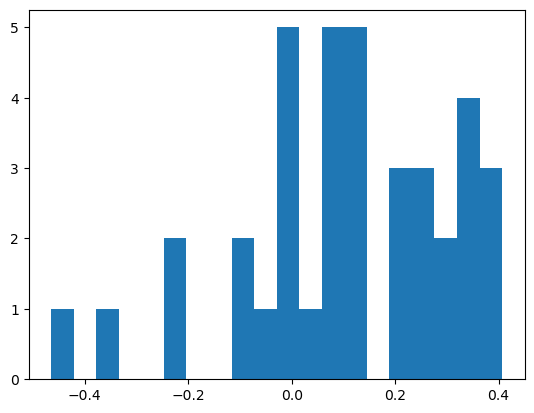

In [71]:
plt.figure() 
plt.hist(synth_drug.yhat, bins=20) 
plt.show() 

In [72]:
y_res = synth_drug.sort_values('yhat', ascending=False).head(1) 
y_sens= synth_drug.sort_values('yhat', ascending=True).head(1) 

x_res = xs[y_res.index.values[0]]
x_sens = xs[y_sens.index.values[0]] 

print('y res value: ', y_res.yhat.values[0])
print('y sens value: ', y_sens.yhat.values[0])


y res value:  0.40660724
y sens value:  -0.46521455


In [73]:
torch.cuda.empty_cache() 

explainer = ContrastiveIGExplainer(model, data, n_steps=50) 

ig_res = explainer.explain(x_res, x_sens, target_idx=0)

ig_res.head() 


,source,target,score
0,PROTEIN__O00444,PROTEIN__Q9HC77,0.000068
1,PROTEIN__O00444,PROTEIN__Q96RT7,0.000101
2,PROTEIN__O00444,PROTEIN__Q8NHV4,-0.000048
3,PROTEIN__O00444,PROTEIN__Q9UPN4,0.000053
4,PROTEIN__O00444,PROTEIN__Q8TDX7,-0.000066


In [74]:
ig_res.sort_values('score', ascending=False).head(5)

,source,target,score
120889,EXPR__Q09472,RNA__Q09472,0.033068
122466,EXPR__Q14493,RNA__Q14493,0.025519
122827,EXPR__P25490,RNA__P25490,0.017922
45,PROTEIN__P10415,PROTEIN__Q13315,0.017753
121557,EXPR__P31749,RNA__P31749,0.016901


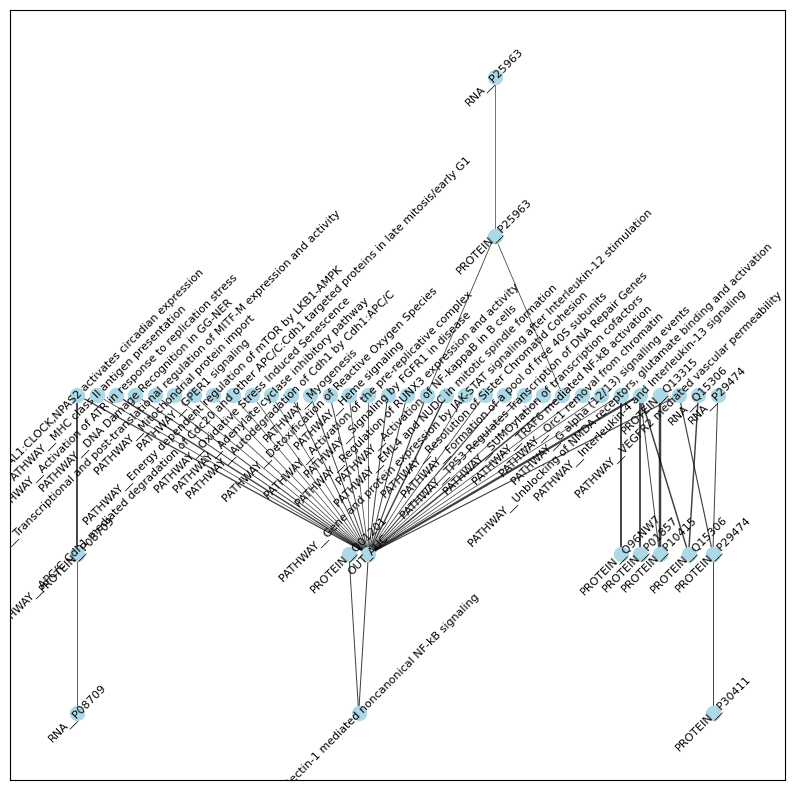

In [75]:
G = nx.from_pandas_edgelist(ig_res[lambda x: x.score > 0.005], source='source', target='target', edge_attr='score') 
s = nx.ancestors(G, 'OUT_AUC').union( set(['OUT_AUC']) )
G = G.subgraph(s).copy() 
len(G), len(G.edges())

# use heiarchichal "dot" layout
H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

edge_widths = [G.edges[e]['score'] * 100 for e in G.edges]

plt.figure(figsize=(10,10))
nx.draw_networkx_edges(G, pos, alpha=0.75, width=edge_widths)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nl = nx.draw_networkx_labels(G, pos, font_size=8, )

for _, label in nl.items():
    label.set_rotation(45) # Rotate labels by 45 degrees

plt.show()

# Counterfactual explanations 

In [76]:
cf_explainer = CounterfactualExplainer(model, data) 

# we will only optimize non-drug inputs to look for sensitivity predictors 
trainable_mask = torch.tensor(['DRUG__' not in x for x in data.node_names_dict['input']], dtype=torch.bool)

res = cf_explainer.explain(x_res, target_idx=0, target_value=-0.5, trainable_mask=trainable_mask, 
                            lr=1e-4, dropout=0.5, weight_decay=1)

print(res.attrs)
 
res.sort_values('perturbation', ascending=False)

Iteration 298: Loss = 0.004611
Converged at iteration 298
Final loss: 0.004611
{'converged_loss': 0.004611252341419458, 'iterations': 299, 'batch_size': 1, 'original_prediction': array([[0.40660703]], dtype=float32), 'final_prediction': array([[-0.4401516]], dtype=float32), 'target_value': array([[-0.5]], dtype=float32)}


,feature,original,perturbation,counterfactual
1141,EXPR__Q9NPP4,0.149564,0.017714,0.167278
2725,EXPR__Q8NFD5,0.193094,0.016252,0.209345
1569,EXPR__O95180,0.002813,0.015231,0.018044
519,EXPR__Q7Z5H3,0.060893,0.014271,0.075164
1143,EXPR__Q13705,0.229542,0.013702,0.243244
...,...,...,...,...
1331,EXPR__P28749,0.258183,-0.013362,0.244821
583,EXPR__Q9NZC2,0.005571,-0.014013,-0.008442
2744,EXPR__Q9UPM9,0.051727,-0.014446,0.037281
1380,EXPR__A1A4S6,0.100723,-0.015085,0.085637


In [77]:
res.perturbation.abs().sum() 

10.815943

In [78]:
torch.cuda.empty_cache() 

In [79]:
# now contrastive ig to see what latent vars are driving the difference 
x_res2 = torch.tensor(res.counterfactual.values, dtype=torch.float32).view(1, -1)

c_explainer = NoiseTunnel(ContrastiveIGExplainer(model, data, n_steps=50), n_samples=10)
#c_explainer = ContrastiveOcclusionExplainer(model, data, verbose=True) 

res_c = c_explainer.explain(x_res.view(1, -1), x_res2, target_idx=0)

res_c.sort_values('score', ascending=False)

,source,target,score
60,PROTEIN__P10415,PATHWAY__Estrogen-dependent nuclear events dow...,0.012743
119999,DRUG__venetoclax,PROTEIN__P10415,0.012006
54,PROTEIN__P10415,PROTEIN__P24385,0.008276
123392,PATHWAY__Interleukin-4 and Interleukin-13 sign...,OUT_AUC,0.007098
41785,RNA__P78396,PROTEIN__P78396,0.007042
...,...,...,...
121158,EXPR__Q15382,RNA__Q15382,-0.002922
46680,RNA__P63261,PROTEIN__P63261,-0.002928
43929,RNA__O15111,PROTEIN__O15111,-0.003886
121639,EXPR__O15111,RNA__O15111,-0.004633


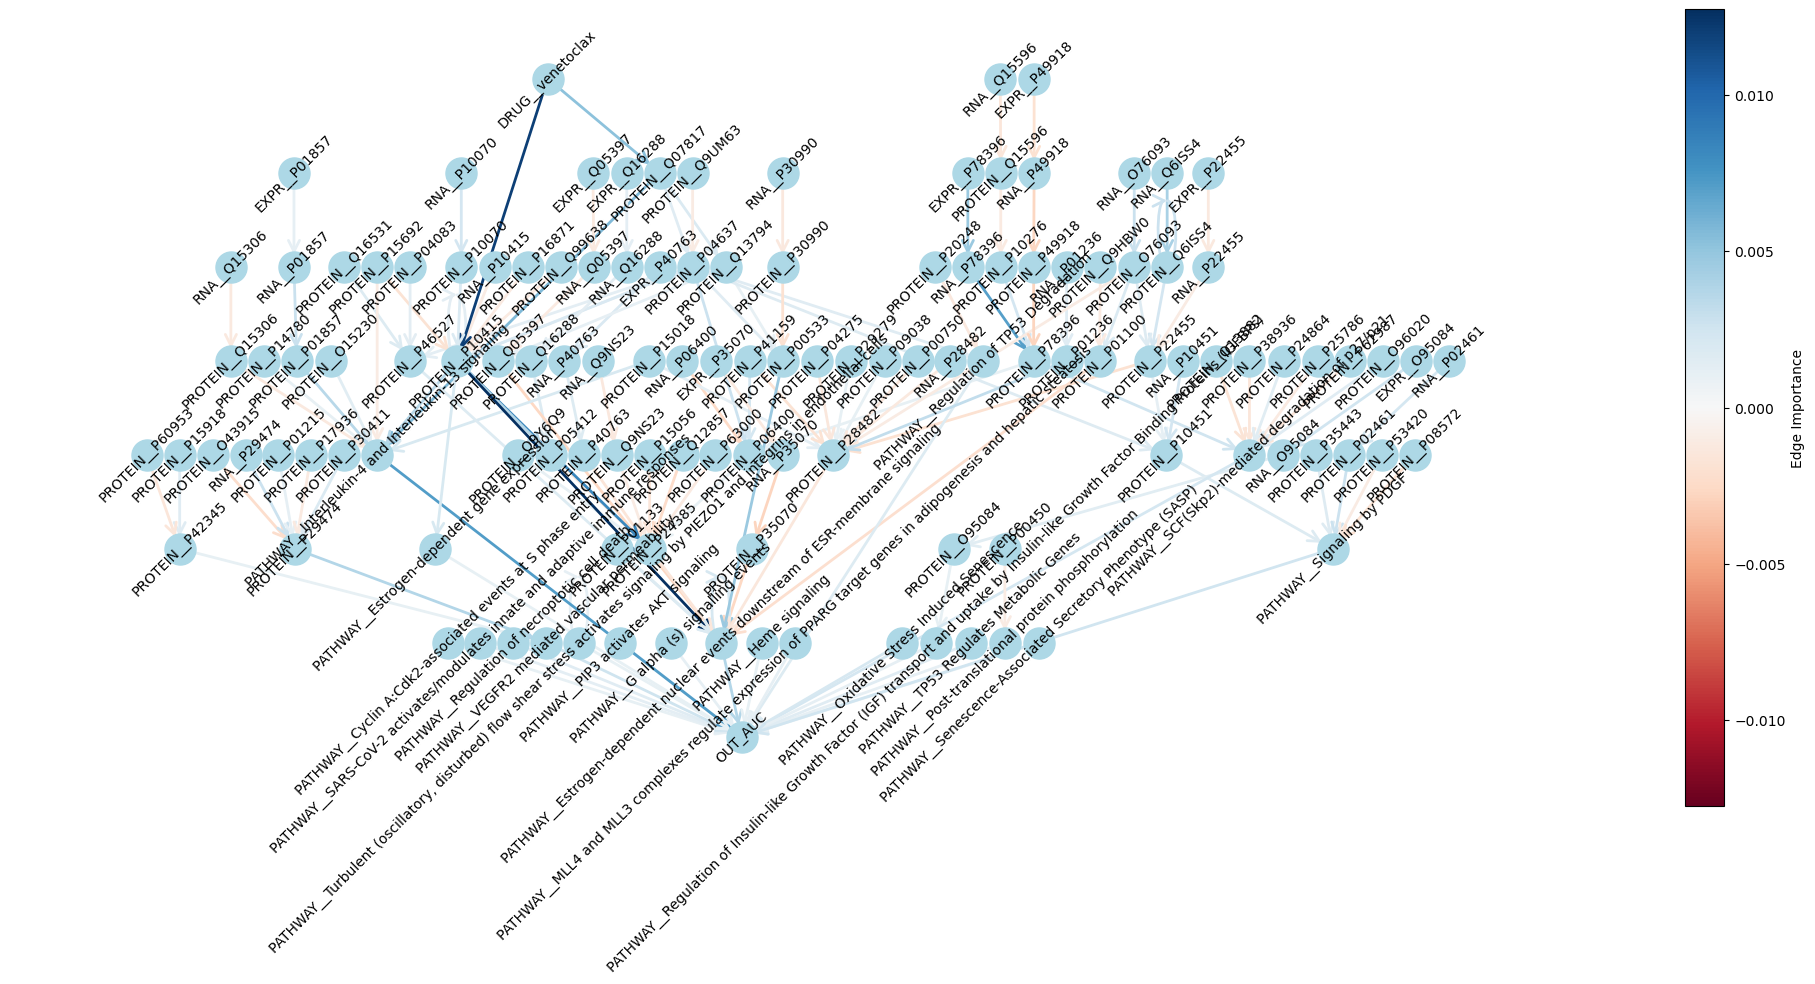

In [80]:
plot_edge_importance(res_c[lambda x: x.score.abs() > 0.001], figsize=(20,10), root='OUT_AUC')

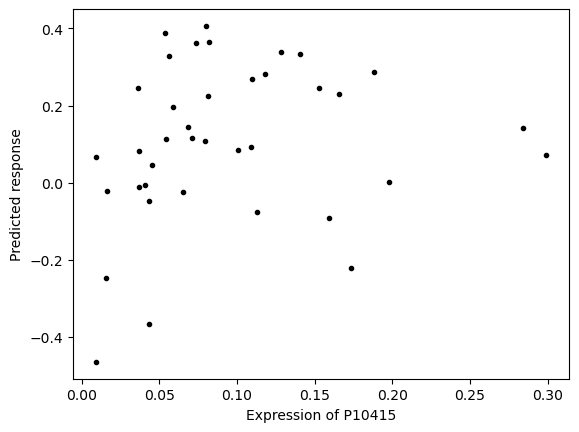

In [83]:
gene = 'P10415'

xx = x[:, data.node_names_dict['input'].index(f'EXPR__{gene}')]

plt.figure() 
plt.plot(xx.detach().cpu().numpy(), yhat.detach().cpu().numpy(), 'k.')
plt.xlabel(f'Expression of {gene}')
plt.ylabel('Predicted response')
plt.show()  

# Try a slightly different approach... 

for the top N most resistant patients, can we find an counterfactual example that increases sensitivity? 

In [84]:
x_res_batch = x[synth_drug.sort_values('yhat', ascending=False).head(10).index.values]
print(x_res_batch.shape)

cf_explainer = CounterfactualExplainer(model, data) 

# we will only optimize non-drug inputs to look for sensitivity predictors 
trainable_mask = torch.tensor(['DRUG__' not in x for x in data.node_names_dict['input']], dtype=torch.bool)

res = cf_explainer.explain(x_res_batch, target_idx=0, target_value=0, trainable_mask=trainable_mask, 
                            lr=1e-4, dropout=0., weight_decay=10)

print(res.attrs)
 
res.sort_values('perturbation', ascending=False)

torch.Size([10, 2910])
Iteration 221: Loss = 0.022330
Converged at iteration 221
Final loss: 0.022330
{'converged_loss': 0.02232968993484974, 'iterations': 222, 'batch_size': 10, 'original_prediction': array([[0.4066072 ],
       [0.38696262],
       [0.36405963],
       [0.36124703],
       [0.33782926],
       [0.3327503 ],
       [0.3295461 ],
       [0.28781274],
       [0.2821282 ],
       [0.26877773]], dtype=float32), 'final_prediction': array([[0.19160563],
       [0.17992611],
       [0.1829703 ],
       [0.13393016],
       [0.18559813],
       [0.07989015],
       [0.12904833],
       [0.09268198],
       [0.1549744 ],
       [0.11231069]], dtype=float32), 'target_value': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)}


,feature,original,perturbation,counterfactual
2063,EXPR__Q92859,0.010393,0.016120,0.026513
852,EXPR__P29317,0.027237,0.011187,0.038423
661,EXPR__O95271,0.095130,0.010195,0.105325
1539,EXPR__Q9Y2T1,0.034765,0.009971,0.044736
760,EXPR__Q9P2W1,0.217749,0.008561,0.226310
...,...,...,...,...
7,EXPR__P37840,0.055809,-0.008576,0.047233
18,EXPR__P36952,0.000192,-0.008795,-0.008603
1606,EXPR__O15438,0.053572,-0.010523,0.043048
1782,EXPR__P43268,0.011408,-0.011175,0.000233


In [85]:
res.perturbation.abs().sum() 

1.8493125

In [ ]:
# Take TOP 10, do we still see sensitive signature? 

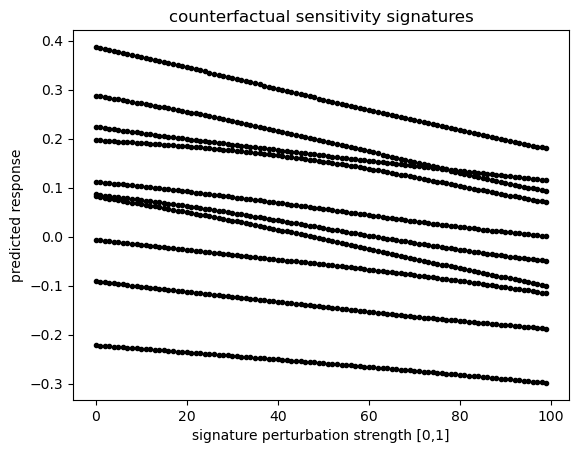

In [86]:
# choose some other random patients 
x_batch = x[synth_drug.sample(30).index.values]

x_sig = torch.tensor(res.perturbation.values, dtype=torch.float32).view(1, -1).cuda()

plt.figure() 

for i in range(10): 
    xxx = x_batch[[i]].expand(100, -1) + x_sig.expand(100, -1)*torch.linspace(0, 1, 100).view(100, 1).cuda() 
    with torch.no_grad(): yhat = model(xxx).detach().cpu().numpy() 

    plt.plot(yhat, 'k.') 

plt.xlabel('signature perturbation strength [0,1]')
plt.ylabel('predicted response')
plt.title('counterfactual sensitivity signatures')

plt.show() 

## Try counterfactuals with drugs, look for combos 

In [164]:
x_res_batch = x[synth_drug.sort_values('yhat', ascending=False).head(10).index.values]

drug_ixs = torch.tensor([i for i,n in enumerate(data.node_names_dict['input']) if 'DRUG__' in n], dtype=torch.long)

x_drug_prob = torch.zeros(1, drug_ixs.shape[0], device=x_res_batch.device, requires_grad=True)  

optim = torch.optim.Adam([x_drug_prob], lr=1e-2) 

losses = [] 
for i in range(1000): 
    optim.zero_grad() 
    x_drug = torch.nn.functional.gumbel_softmax(x_drug_prob, dim=-1, hard=True, tau=3)  
    xx = x_res_batch.clone() 
    xx[:, drug_ixs] = x_drug 
    yhat = model(xx) 
    loss = yhat.mean() 
    loss.backward() 
    optim.step() 
    print(i, loss.item(), end='\r') 
    losses.append(loss.item()) 

drug_comb_res = pd.DataFrame({'inhibitor':np.array(data.node_names_dict['input'])[drug_ixs], 'prob':x_drug_prob.softmax(dim=-1).detach().cpu().numpy().flatten()})



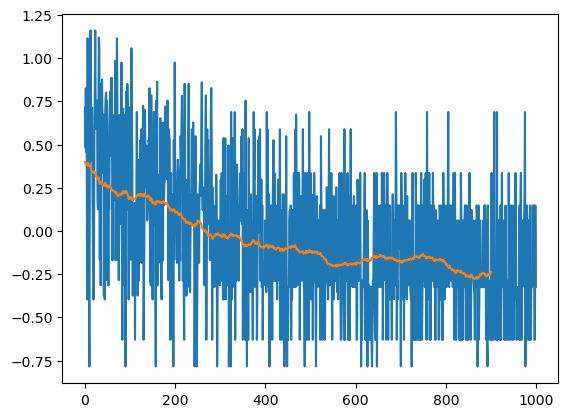

In [165]:
plt.figure() 
plt.plot(losses) 
# running mean 
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid')) 
plt.show() 

In [ ]:
# TODO: filter to high performance drugs 

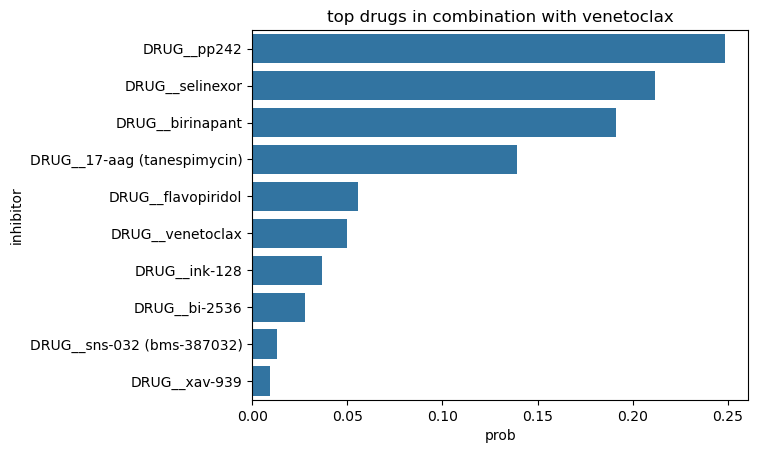

In [166]:
plt.figure() 
sbn.barplot(y='inhibitor', x='prob', orient='h', data=drug_comb_res.sort_values('prob', ascending=False).head(10)) 


plt.title('top drugs in combination with venetoclax')
plt.show() 

In [ ]:
#Combination venetoclax and selinexor effective in relapsed refractory multiple myeloma with translocation t(11;14) - https://pmc.ncbi.nlm.nih.gov/articles/PMC9581939/